In [1]:
from utils.plot_metrics import display_metrics, display_best_performance_barchart


delay_studies = {
    "no delay": "saves/phase1/ablation/delay/0_0/epoch_21",
    "0.15s": "saves/phase1/ablation/delay/0_15/epoch_26",
    "0.30s": "saves/phase1/ablation/delay/0_30/epoch_26",
    "0.45s": "saves/phase1/ablation/delay/0_45/epoch_24",
}

baseline_studies = {
    "no correction": "saves/phase1/ablation/baseline_corr/baseline_none/epoch_26",
    "0.5s": "saves/phase1/ablation/delay/0_15/epoch_26",
    "5s": "saves/phase1/ablation/baseline_corr/baseline_5_sec/epoch_24",
    "10s": "saves/phase1/ablation/baseline_corr/baseline_10_sec/epoch_20",
}

clipping_studies = {
    "no clpping": "saves/phase1/ablation/clipping/none/epoch_26",
    "10std": "saves/phase1/ablation/clipping/10std/epoch_21",
    "20std": "saves/phase1/ablation/delay/0_15/epoch_26",
    "30std": "saves/phase1/ablation/clipping/30std/epoch_23",
    "40std": "saves/phase1/ablation/clipping/40std/epoch_27",
}

band_pass_filters = {
    "(0.5, None), 100Hz": "saves/phase1/ablation/bandpass/none/epoch_22",
    "(0.5, 40), 100Hz": "saves/phase1/ablation/bandpass/40/epoch_27",
    "(0.5, 80), 100Hz": "saves/phase1/ablation/clipping/none/epoch_26",
    "(0.5, 100), 100Hz": "saves/phase1/ablation/bandpass/100/epoch_25",
    "(0.5, 40), 200Hz": "saves/phase1/ablation/downsample200/40/epoch_19",
    "(0.5, 80), 200Hz": "saves/phase1/ablation/downsample200/80/epoch_23",
    "(0.5, 100), 200Hz": "saves/phase1/ablation/downsample200/100/epoch_24",
}

# # Using a moving average window of 5 to smooth the curves
# display_metrics(
#     studies,
#     train_metrics=["accuracy", "top_5_accuracy", "top_10_accuracy"],
#     test_metrics=["accuracy", "top_5_accuracy", "top_10_accuracy"],
#     smooth_window=1,
#     test_subset="unseen_task",
# )

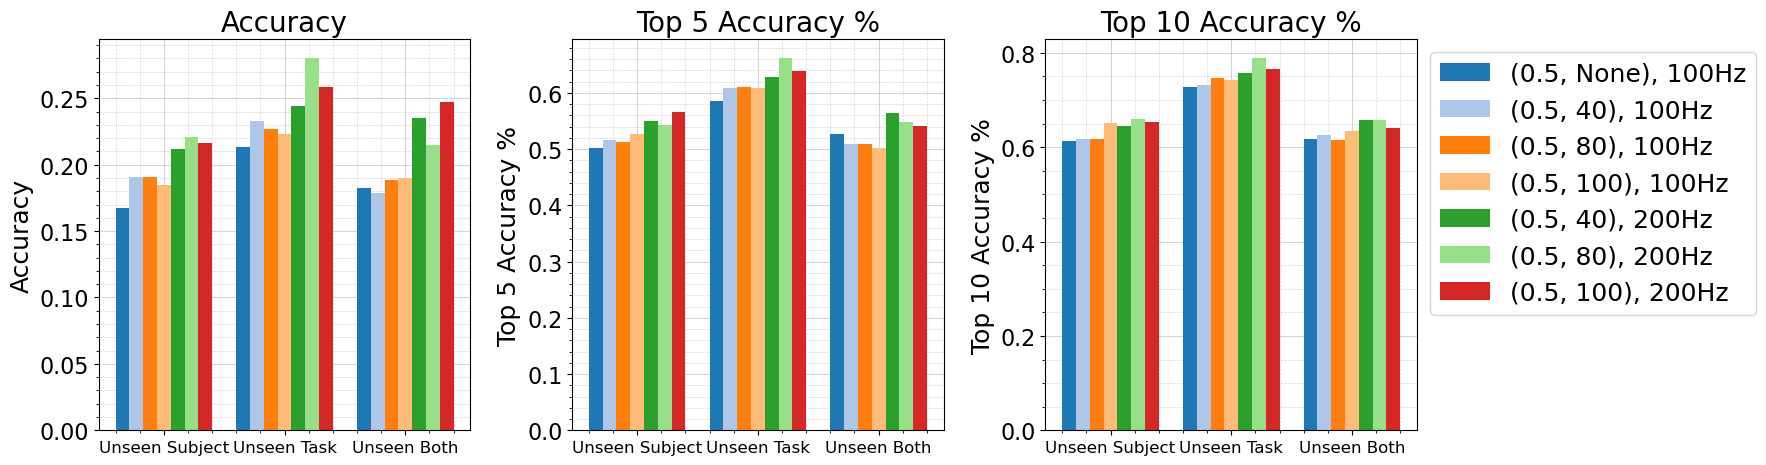

In [4]:
display_best_performance_barchart(
    band_pass_filters,
    test_metrics=["accuracy", "top_5_accuracy", "top_10_accuracy"],
    test_subsets=["unseen_subject", "unseen_task", "unseen_both"],
    top_percent=True,
)

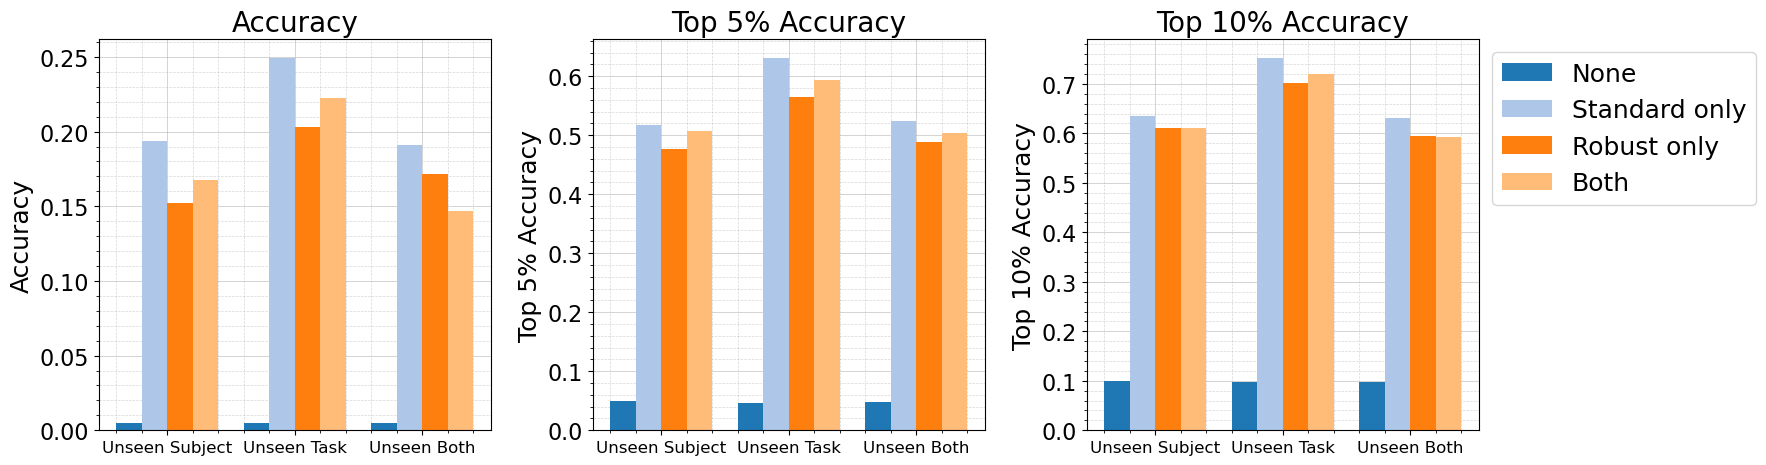

In [14]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator


def enable_fine_grid(ax):
    """Enable major and minor axis grid"""
    ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.75)
    ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.5)

    # Turn on minor ticks for both axes
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())


def plot_custom_barchart(
    data: dict,
    test_metrics: list,
    test_subsets: list,
):
    """
    Given a dictionary of results for multiple "studies" (e.g., 'None (BN)', 'Standard', 'Robust', 'Both'),
    plots a grouped bar chart for each metric across the specified test subsets.

    Parameters:
    -----------
    data : dict
        Nested dictionary of the form:
        {
          "StudyName": {
              "unseen_subject": {"Accuracy": float, "top_1": float, "top_5": float, "top_10": float},
              "unseen_task":    {"Accuracy": float, "top_1": float, "top_5": float, "top_10": float},
              "unseen_both":    {"Accuracy": float, "top_1": float, "top_5": float, "top_10": float}
          },
          ...
        }
    test_metrics : list of str
        The metrics you want to plot, e.g. ["Accuracy", "top_1", "top_5", "top_10"].
    test_subsets : list of str
        The category subsets, e.g. ["unseen_subject", "unseen_task", "unseen_both"].
    """

    # Safety checks
    if len(test_metrics) == 0 or len(test_subsets) == 0:
        print("No test metrics or test subsets provided.")
        return

    # Try to use seaborn-whitegrid style; if not available, revert to default
    try:
        plt.style.use("seaborn-whitegrid")
    except OSError:
        print(
            "Warning: 'seaborn-whitegrid' style is not available. Using default style."
        )
        plt.style.use("default")

    # We pick a color palette
    sns.set_palette("tab20", len(data))

    # Configure fonts and style
    mpl.rcParams.update(
        {
            "font.size": 18,
            "axes.titlesize": 20,
            "axes.labelsize": 18,
            "xtick.labelsize": 12,
            "ytick.labelsize": 16,
            "legend.fontsize": 18,
        }
    )
    mpl.rcParams.update()

    # Prepare figure with one subplot per test metric
    n_metrics = len(test_metrics)
    fig, axes = plt.subplots(1, n_metrics, figsize=(6 * n_metrics, 5), squeeze=False)
    axes = axes[0]  # (1, n_metrics) shape, select the row of axes

    # We'll treat each metric as a separate subplot
    study_titles = list(data.keys())  # e.g. ["None (BN)", "Standard only", ...]
    n_studies = len(study_titles)
    n_categories = len(
        test_subsets
    )  # e.g. 3 for ["unseen_subject", "unseen_task", "unseen_both"]

    # Make sure all subsets exist in all studies; if missing, we'll treat them as np.nan
    # (But here we assume your `data` dict is fairly complete.)

    # For each metric, we do a grouped bar for each study
    bar_width = 0.8 / n_studies
    x_positions = np.arange(n_categories)

    for i, metric in enumerate(test_metrics):
        ax = axes[i]
        enable_fine_grid(ax)
        ax.set_axisbelow(True)

        for j, study_title in enumerate(study_titles):
            # Prepare the y-values for the current metric
            vals = []
            for subset_name in test_subsets:
                # If the subset or metric is missing, use np.nan
                val = np.nan
                if subset_name in data[study_title]:
                    val = data[study_title][subset_name].get(metric, np.nan)
                vals.append(val)

            # Compute the bar positions for this study
            offset = (j - (n_studies - 1) / 2) * bar_width
            bar_positions = x_positions + offset

            # Plot the bars
            ax.bar(bar_positions, vals, width=bar_width, label=study_title)

        # Set ticks, labels, etc.
        ax.set_xticks(x_positions)
        # Turn "unseen_subject" -> "Unseen Subject" for aesthetics
        formatted_subsets = [s.replace("_", " ").title() for s in test_subsets]
        ax.set_xticklabels(formatted_subsets, rotation=0)
        tit = metric.replace("_", " ").title()
        tit = tit + "% Accuracy" if tit != "Accuracy" else tit
        ax.set_title(tit)
        ax.set_ylabel(tit)

        # Add the legend once, on the right side of the last subplot
        if i == n_metrics - 1:
            ax.legend(study_titles, loc="best", bbox_to_anchor=(1.0, 1.0))

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Example usage with your data
    test_data = {
        "None": {
            "unseen_subject": {
                "Accuracy": 0.0049,
                "top_5": 0.0494,
                "top_10": 0.0988,
            },
            "unseen_task": {
                "Accuracy": 0.0051,
                "top_5": 0.0470,
                "top_10": 0.0975,
            },
            "unseen_both": {
                "Accuracy": 0.0050,
                "top_5": 0.0472,
                "top_10": 0.0969,
            },
        },
        "Standard only": {
            "unseen_subject": {
                "Accuracy": 0.1936,
                "top_5": 0.5166,
                "top_10": 0.6345,
            },
            "unseen_task": {
                "Accuracy": 0.2493,
                "top_5": 0.6310,
                "top_10": 0.7524,
            },
            "unseen_both": {
                "Accuracy": 0.1909,
                "top_5": 0.5236,
                "top_10": 0.6312,
            },
        },
        "Robust only": {
            "unseen_subject": {
                "Accuracy": 0.1523,
                "top_5": 0.4774,
                "top_10": 0.6115,
            },
            "unseen_task": {
                "Accuracy": 0.2033,
                "top_5": 0.5646,
                "top_10": 0.7015,
            },
            "unseen_both": {
                "Accuracy": 0.1718,
                "top_5": 0.4894,
                "top_10": 0.5949,
            },
        },
        "Both": {
            "unseen_subject": {
                "Accuracy": 0.1677,
                "top_5": 0.5074,
                "top_10": 0.6115,
            },
            "unseen_task": {
                "Accuracy": 0.2222,
                "top_5": 0.5937,
                "top_10": 0.7192,
            },
            "unseen_both": {
                "Accuracy": 0.1470,
                "top_5": 0.5042,
                "top_10": 0.5927,
            },
        },
    }

    # We'll pick which metrics to display in separate subplots
    test_metrics = ["Accuracy", "top_5", "top_10"]
    # We'll pick which subsets for the x-axis
    test_subsets = ["unseen_subject", "unseen_task", "unseen_both"]

    # Now plot
    plot_custom_barchart(
        data=test_data,
        test_metrics=test_metrics,
        test_subsets=test_subsets,
    )